In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hs_2028_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\pu_with_proj_SPLIT.geojson').to_crs(epsg=3857)
hs_2028_geo.head(2)

,pu_2324_84,student_gen,basez,final_proj,geometry
0,1,0,0.0,0.0,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,0,4.0,4.0,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."


In [13]:
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs = dps_base_hs[['name','geometry']]
dps_base_hs.loc[5,'name']='New High School'
dps_base_hs = dps_base_hs.reset_index()

In [14]:
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_Files\\pu_2324_SPLIT.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu.head(2)

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."


In [69]:
def score_candidate(candidate):
    school_names = ['Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
    capacities = [1300,1200,1100,1100,1210,1300]

    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0],
                           'adjust':[0,0,0,0,0,0]
                            })                              

    
    candidate_geom = candidate['geometry']
    dps_base_hs.loc[5,'geometry']=candidate_geom.centroid
    

    for i in range(50):                                    
        assignments = []
        for pu in hs_2028_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(6):    
                dist = centroid.distance(dps_base_hs.loc[j,'geometry'])
                score = dist + counts.loc[j,'adjust']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)
        hs_2028_geo['assign'] = assignments

        for j,school in enumerate(school_names):
            assigned_students = hs_2028_geo.loc[hs_2028_geo['assign'] == school, 'final_proj'].sum()
            counts.loc[j, 'count'] = assigned_students  
            
            if counts.loc[j,'count'] - counts.loc[j,'capacity'] <= -100:
                counts.loc[j,'adjust'] -= 15 * (50-i)
            elif counts.loc[j,'count'] - counts.loc[j,'capacity'] >= 0:
                counts.loc[j,'adjust'] += 15 * (50-i)
            else:
                pass
        
    objective=hs_2028_geo.merge(dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = (objective['final_proj']*objective['distance']).sum()/(10**7)

    return objective_score,counts
score_candidate(dps_pu.loc[566])

(3.7163868610360087,
                   school  capacity  count  adjust
 0   Southern High School      1300   1272    6735
 1   Hillside High School      1200   1144    6660
 2   Northern High School      1100   1094     690
 3  Riverside High School      1100   1220   -1785
 4     Jordan High School      1210   1190    6060
 5        New High School      1300   1095   -1905)

<Axes: title={'center': 'Expanded HS Boundaries'}>

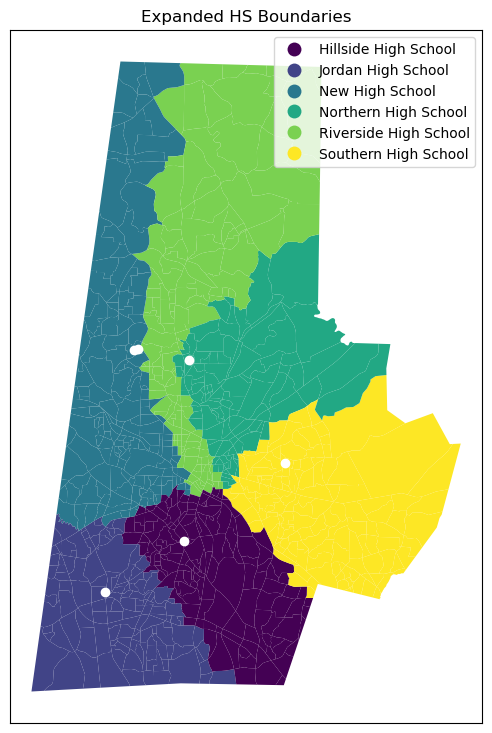

In [70]:
fig,ax = plt.subplots(figsize = (7,9))

hs_2028_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
dps_base_hs.plot(ax=plt.gca(), color = 'white')

In [32]:
single_reg = dps_base[~dps_base['region_base'].isin(['district-wide','regional (SW, SE, C)'])]
dps_base_ms = single_reg[single_reg['name'].str.contains('Middle School')]
print(dps_base_ms.columns)

Index(['OBJECTID', 'facilityid', 'sch_id6', 'sch_id', 'name', 'address',
       'phone', 'agencyurl', 'operhours', 'spectype', 'grades_2324',
       'grades_2425', 'grades_2526', 'shortname', 'y_wgs84', 'x_wgs84',
       'sch_type_2324', 'sch_type_2425', 'sch_type_2526', 'region_base',
       'region_physical', 'calendar_2324', 'calendar_2425', 'choice_2324',
       'choice_2425', 'choice_2526', 'x_ncplane', 'y_ncplane', 'geometry'],
      dtype='object')
